### Treść zadania

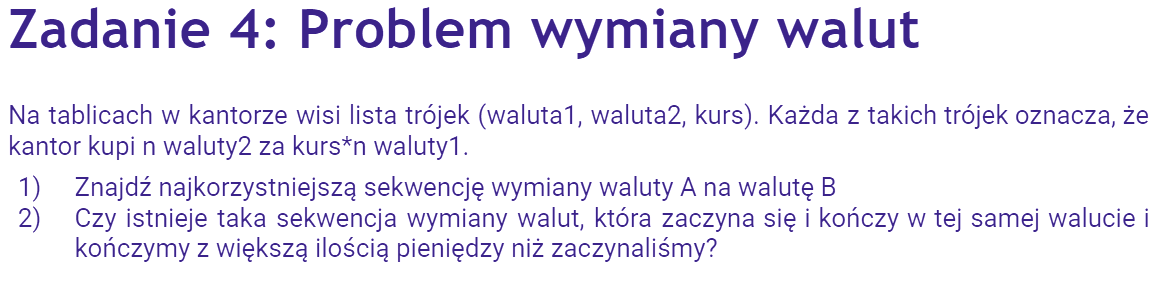

### UWAGI

Odtwarzenie rozwiązania nie jest jednak tak trywialne, jak było to powiedziane w 2. nagraniu z BIT Algo wyżej. Wynika to stąd, że jeżeli mamy ujemny cykl, to po wejściu w ten cykl, w tablicy rodziców będą zapisane takie wierzchołki, które tworzą ten cykl, przez co do naszej ścieżki będziemy dokładać nieskończenie wiele wierzchołków z cyklu, jeżeli wierzchołek startowy leży poza cyklem. W tym przypadku, ponieważ mamy ujemny cykl, podczas odtwarzania ścieżki musimy zapamętywać odwiedzone wierzchołki. Jeżeli będziemy próbowali odwiedzić ponownie dodany już do ścieżki wierzchołek, to mamy cykl, więc przerywamy pętlę, w której korzystaliśmy z tablicy rodziców i jakoś oznaczmy wierzchołki, które tworzą cykl (ponieważ wówczas nie istnieje najkorzystniejsza skończona sekwencja, to w tej sekwencji znaleźć się musi cykl, który oznaczymy jako krotka wierzchołków, kóre wchodzą w jego skład). W ten sposób otrzymamy tylko fragment ścieżki (rozważamy przypadek, gdy wierzchołek startowy leży poza ujemnym cyklem), który będzie składał się z cyklu oraz ścieżki, jaka prowadzi od tego cyklu do celu, a więc musimy jeszcze dostać ścieżkę od wierzchołka startowego do tego cyklu. Tu wystarczy jednak użyć algorytmu DFS/BFS i znaleźć dowolną ścieżkę z wierzchołka startowego do jakiegokolwiek wierzchołka, który leży na ujemnym cyklu, ponieważ ten ujemny cykl powoduje, że i tak sumaryczna waga krawędzi z całej sekwencji (która jest nieskończona z uwagi na cykl), będzie równa $ -\infty $.

# Wersja I
### (Jeżeli uznamy, że istnieją takie waluty, że jednej nie można wymienić na drugą - nie mamy grafu pełnego)
##### (Bellman-Ford)

### Złożoność

###### Obliczeniowa:
$ O(VE) $ - bo taka jest złożoność algorytmu Bellmana-Forda
###### Pamięciowa:
$ O(V + E) $ - bo tworzymy graf

### Implementacja

In [1]:
import math


def bellman_ford(G: 'graph represented by adjacency lists', s: 'source'):
    n = len(G)
    inf = float('inf')
    weights = [inf] * n
    parents = [[] for _ in range(n)]
    weights[s] = 0
    
    # Calculate shortest paths distances
    for _ in range(n):
        for u in range(n):
            for v, weight in G[u]:
                if weights[u] + weight < weights[v]:
                    weights[v] = weights[u] + weight
                    parents[v] = u
                
    # Look for negative cycles and replace distances
    # with a -infinity if a vertex is affected by
    # a negative cycle
    for _ in range(n):
        for u in range(n):
            for v, weight in G[u]:
                # If we still can relax a u vertex, there
                # must be a negative cycle
                if weights[u] + weight < weights[v]:
                    weights[v] = -inf
        
    return weights, parents


def create_graph(E):
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    
    G = [[] for _ in range(n)]
    for e in E:
        G[e[1]].append((e[0], math.log(e[2])))
        
    # Add a sentinel vertex which is linked to all
    # other vertices
    G.append([(i, 1) for i in range(n)])
    return G


def has_negative_cycle(weights):
    for w in weights:
        if w == float('-inf'):
            return True
    return False

    
def get_shortest_path_with_cycle(G, parents, s, t):
    # If no path exists
    if parents[t] is None: return []
    it = 0
    n = len(parents)
    iters = [-1] * n
    seq = []
    
    last_u = None
    
    while t is not None:
        # Check if we visited the same vertex again
        # (If we have a negative cycle)
        if iters[t] >= 0:
            cycle = tuple(seq[i] for i in range(len(seq) - 1, iters[t] - 1, -1))
            last_u = cycle[0]
            for i in range(len(seq) - iters[t]): seq.pop()
            seq.append(cycle)
            break
        seq.append(t)
        iters[t] = it
        t = parents[t]
        it += 1
        
    # If there was a cycle
    if last_u is not None:
        new_parents = [None] * n

        def dfs(u):
            if u == last_u: return
            for v, _ in G[u]:
                if new_parents[v] is None:
                    new_parents[v] = u
                    dfs(v)

        new_parents[s] = s
        dfs(s)
        new_parents[s] = None
        
        u = new_parents[last_u]
        while u is not None:
            seq.append(u)
            u = new_parents[u]
    
    seq.reverse()
    return seq
    
    
def exchange(E: 'array of exchange rates triplets',
             a: 'initial currency',
             b: 'target currency'):
    G = create_graph(E)
    n = len(G)
    weights, parents = bellman_ford(G, a)
    seq = get_shortest_path_with_cycle(G, parents, a, b)
    weights, parents = bellman_ford(G, n - 1)
    can_increase = has_negative_cycle(weights)
    return seq, can_increase

###### Kilka testów

##### Pomocnicze

In [2]:
def map_seq(seq, currencies):
    res = []
    for s in seq:
        if isinstance(s, tuple):
            res.append(tuple(currencies[n] for n in s))
        else:
            res.append(currencies[s])
    return res

def test(rates, currencies, a, b):
    seq, can_get_more = exchange(E, a, b)
    print('Can increase the amount of money?', can_get_more)
    print(f'Best exchange sequence from {currencies[a]} to {currencies[b]}:', map_seq(seq, currencies))

###### UWAGA: Graf powinien być skierowany w drugą stronę
To, że mamy trójkę $ (PLN, EUR, 4.49) $ oznacza tyle, że kantor kupuje od nas euro, a nie złotówki i wypłaca nam w złotówkach, płacą nam $ kurs \cdot waluta1 $, czyli ta krotka pozwala nam wymienić euro na złotówki, gdzie za $ 1 $ euro dostajemy $ 4.49 $.
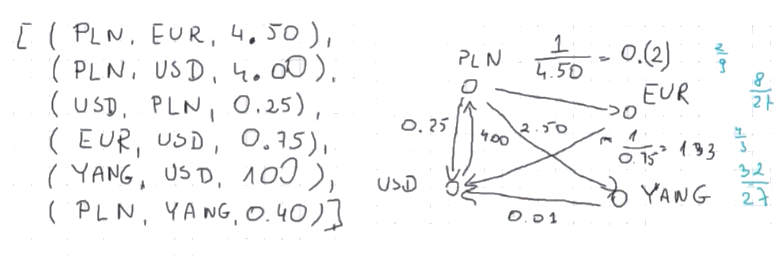

In [3]:
PLN = 0; EUR = 1; USD = 2; YANG = 3
E = [(PLN, EUR, 4.5), (PLN, USD, 4), (USD, PLN, .25), (EUR, USD, .75), (YANG, USD, 100), 
     (PLN, YANG, .4)]

currencies = ['PLN', 'EUR', 'USD', 'YANG']

test(E, currencies, EUR, USD)

Can increase the amount of money? True
Best exchange sequence from EUR to USD: [('EUR', 'PLN', 'USD')]


In [4]:
test(E, currencies, YANG, USD)

Can increase the amount of money? True
Best exchange sequence from YANG to USD: ['YANG', 'PLN', 'USD', ('EUR', 'PLN', 'USD')]


In [5]:
test(E, currencies, YANG, PLN)

Can increase the amount of money? True
Best exchange sequence from YANG to PLN: ['YANG', 'PLN', ('USD', 'EUR', 'PLN')]


In [6]:
test(E, currencies, YANG, EUR)

Can increase the amount of money? True
Best exchange sequence from YANG to EUR: ['YANG', ('PLN', 'USD', 'EUR')]


# Wersja II
### (Jeżeli każdą walutę da się wymienić na każdą inną - mamy graf pełny)
##### (Bellman-Ford)

Ponieważ i tak na wejściu musimy otrzymać wszystkie kursy wymiany w obie strony z danej waluty na inną i vice versa, sposób tworzenia grafu się nie zmienia (poza jednym szczegółem - patrz niżej)

    def create_graph(E):
        n = 0
        for e in E:
            n = max(n, e[0], e[1])
        n += 1

        G = [[] for _ in range(n)]
        for e in E:
            G[e[1]].append((e[0], math.log(e[2])))

        G.append([(i, 1) for i in range(n)])  <-- Z dodawania wierzchołka, z którego 
        return G                                  prowadzą krawędzie o wagach 1 do
                                                  wszystkich innych wierzchołków,
                                                  można zrezygnować

Zaznaczyłem wyżej zmianę, którą można wprowadzić. Wynika to stąd, że każdą walutę możemy uzyskać w sposób bezpośredni, poprzez wymianę bężacej waluty na tę walutę (graf pełny). W takiej sytuacji można się również pokusić o użycie algorytmu Floyda-Warshalla, ponieważ $ E = V^2 $, więć $ O(VE) = O(V^3) $ (złożoność będzie taka sama jak dla Bellmana-Forda). Wtedy jednak konieczne jest trzymanie grafu w postaci macierzy, co jest bardzo rozsądne w przypadku grafów płełnych, ponieważ mamy dzięki temu w dodatku natychmiastowy dostęp do wagi krawędzi między wybraną parą wierzchołków $ u, v $, ale nie jest nam to potrzebne.
###### UWAGA
Opisana wyżej modyfikacja dotyczy jedynie znajdowania ujemnego cyklu, czyli drugiego podpunktu zadania, polegającego wyłacznie na stwierdzeniu, czy istnieje taki ciąg operacji, po którym wyjdziemy na plus. Jeżeli chodzi o wyznaczanie ciągu operacji przy wymianie waluty $ A $ na walutę $ B $, możemy wówczas użyć osobno Bellmana-Forda, startując tym razem z wierzchołka, który odpowiada walucie $ A $. Zauważmy, że skoro graf jest grafem pełnym, nie jest istotne to, z którego wierzchołka zaczynamy. Zatem wystarczy wywołać algorytm tylko raz, z wierzchołka, który odpowiada walucie $ A $, a następnie na wyznaczoncyh wagach szukać ujemnych cykli. Wystarczy więc zmienić jeszcze tę linijkę kodu:

    weights, parents = bellman_ford(G, n - 1)

na poniższą linijkę kodu:

    weights, parents = bellman_ford(G, a)

Wówczas poszukiwanie cykli o ujemnej wadze, realizowane przez poniższą linijkę kodu:

    has_negative_cycle(weights)

będzie działało w odpowiedni sposób (jak wcześniej) (ale tylko gdy GRAF jest grafem PEŁNYM).

# Wersja III
### (Jeżeli każdą walutę da się wymienić na każdą inną - mamy graf pełny)
##### (Floyd-Warshall)

##### Obserwacja:

Jeżeli graf jest grafem pełnym i istnieje ujemny cykl, to waga każdej ścieżki będzie równa $ -\infty $. Wystarzczy więc sprawdzić dowolną ścieżkę, jaka jest jej sumaryczna waga.

##### Kod:

Nie chce mi się implementować, ponieważ odtwarzanie ścieżki, na której może się znaleźć ujemny cykl, nie jest łatwym zadaniem w przypadku tego algorytmu. Chyba, że założylibyśmy, że sekwencja wymiany z waluty $ A $ na $ B $ nie może zawierać cykli o ujemnych wagach.